<a href="https://colab.research.google.com/github/dungwoong/CSC413Final/blob/main/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dungwoong/CSC413Final.git
%cd CSC413Final

Cloning into 'CSC413Final'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 117 (delta 46), reused 94 (delta 25), pack-reused 0
Receiving objects: 100% (117/117), 406.66 KiB | 12.71 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/CSC413Final


In [2]:
import time
import pandas as pd
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from shufflenetv2 import base_model, se_model, sle_model
from shufflenet_alt import ShuffleNetV2, init_params

# Todos

 - add save model checkpoints to the training loop
 - maybe add stats for alexnet, vgg or something at the end maybe...wait but they're not made for CIFAR...idk
 - note that FLOPs is roughly 2x MMacs. However FLOPs is much higher in other papers cuz input size is higher, so it doesn't mean anything in the greater scheme of things, only when we compare to other models that we train in this study so should be ok.

# Procedure

**Measure**

Training stats: 

 - Params, MMacs(done)
 - train loss, val loss, top1, top5 error for every epoch
 - Time for every epoch, number of batches/images per epoch(can be inferred from the dataset but yea)

Model parameters

- Model label
- batch size
- lr
- Adam betas
- Adam weight decay (1e-4?)

**Hyperparam tuning**

We will look for clear indications of training problems from the training and validations curves for each hyperparameter configuration. We will search based on this, and otherwise we'll do a gridsearch.

For the validation curves, we want the model to converge at a moderate pace. Gridsearch will mostly be done to see if we can get out of any local minima, but otherwise I think the training curve will indicate if there's any problems.

**Model Comparison**

Overall, I think the metrics we wanted to collect is enough. I will consult with papers again...

We want to compare a few things:

 - Params: ShuffleNet was built for mobile devices, so having less params is better.
 - MMacs: More MMacs is worse
 - we can test the model's inference speed later.
 - Performance: 
  - lowest val loss/signs of overfitting, check top1 and top3 error rates. this is a general performance metric.
  - convergence speed: how fast does model converge
  - how stable is the training curve? idk


In [3]:
mean, std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
])
transform_train = torchvision.transforms.Compose([
      torchvision.transforms.RandomCrop(32, padding = 4),
      torchvision.transforms.RandomHorizontalFlip(),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean, std)])

train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform_train)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

print(f"Training data has {train_size} observations, test has {test_size}.")

100%|██████████| 170498071/170498071 [00:06<00:00, 27598382.86it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Training data has 50000 observations, test has 10000.


In [4]:
# TOP 1 and 3 ERROR
from util import top1_error, top3_error, plot_training_curve

# def top3_error(predictions, targets):  # even though it says top5, it's top3 ok...
#     if len(predictions.shape) == 1:
#       predictions = predictions.unsqueeze(1)
#     if len(targets.shape) == 1:
#       targets = targets.unsqueeze(1)
#     with torch.no_grad():
#         _, top5_pred = torch.topk(predictions, k=3, dim=1)
#         top5_correct = top5_pred.eq(targets.expand(top5_pred.size()))
#         correct = top5_correct.float().sum()
#         total = targets.size(0)
#     return correct.item(), total


# def top1_error(predictions, targets):
#     if len(predictions.shape) == 1:
#       predictions = predictions.unsqueeze(1)
#     if len(targets.shape) == 1:
#       targets = targets.unsqueeze(1)
#     with torch.no_grad():
#         _, top1_pred = torch.max(predictions, dim=1)
#         top1_correct = top1_pred.unsqueeze(1).eq(targets)
#         correct = top1_correct.float().sum()
#         total = targets.size(0)
#     return correct.item(), total

In [5]:
# code adapted from https://colab.research.google.com/github/uoft-csc413/2023/blob/master/assets/tutorials/tut04_cnn.ipynb#scrollTo=Ztj0yQO8-TtS

def get_dataloaders(batch_size, test_bsize=64):
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_bsize, shuffle=False, num_workers=1)

  data_loaders = {"train": train_loader, "test": test_loader}
  dataset_sizes = {"train": train_size, "test": test_size}
  return data_loaders, dataset_sizes

def run_epoch(model, loss_fn, optimizer, device, data_loaders, dataset_sizes):
  epoch_loss = {"train": 0.0, "test": 0.0}
  epoch_acc_1 = {"train": 0.0, "test": 0.0}
  epoch_acc_5 = {"train": 0.0, "test": 0.0}  # 5 is actually 3 btw
  
  # running loss for train/test phase
  running_loss = {"train": 0.0, "test": 0.0}
  running_corrects_1 = {"train": 0, "test": 0}
  running_corrects_5 = {"train": 0, "test": 0}

  # time and batch data
  start_time = time.time()
  batches = {"train": 0, "test": 0}

  for phase in ["train", "test"]:
    print(f"Running phase {phase}")
    # set train/eval mode
    if phase == "train":
        model.train(True)
    else:
        model.train(False)
    
    # go thru batches
    for data in data_loaders[phase]:
      batches[phase] += 1
      inputs, labels = data
      
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad() # clear all gradients
      
      outputs = model(inputs) # batch_size x num_classes
      sm_outputs = torch.softmax(outputs, dim=1)
      _, preds = torch.max(outputs.data, 1) # values, indices
      loss = loss_fn(outputs, labels)
      
      if phase == "train":
          loss.backward()  # compute gradients
          optimizer.step() # update weights/biases
          
      running_loss[phase] += loss.data.item() * inputs.size(0)
      c, t = top1_error(sm_outputs, labels.data)
      running_corrects_1[phase] += c
      c2, t2 = top3_error(sm_outputs, labels.data)
      running_corrects_5[phase] += c2
    
      epoch_loss[phase] = running_loss[phase] / dataset_sizes[phase]
      epoch_acc_1[phase] =  running_corrects_1[phase] / dataset_sizes[phase]
      epoch_acc_5[phase] =  running_corrects_5[phase] / dataset_sizes[phase]

  return {"loss": epoch_loss,
          "top1_acc": epoch_acc_1,
          "top3_acc": epoch_acc_5,
          "running_corrects_1": running_corrects_1,
          "running_corrects_3": running_corrects_5,
          "dataset_sizes": dataset_sizes,
          "time": time.time() - start_time,
          "batches": batches}

def flatten_dict(dic, sep='_'):
  ret = dict()
  for key in dic:
    if isinstance(dic[key], dict):
      flat = flatten_dict(dic[key], sep='_')
      for key2 in flat:
        ret[key + sep + key2] = flat[key2]
    else:
      ret[key] = dic[key]
  return ret

def to_df(flattened_dict):
  d = {key: [flattened_dict[key]] for key in flattened_dict}
  return pd.DataFrame(d)

In [14]:
def train(model, device, batch_size, lr, beta0, beta1, weight_decay, checkpoint=None, epochs=100, 
          lr_decay_rate=10, lr_decay_epochs=[], decay_patience=10, csv_path="", models_path="tmp", plot=True, print_results_every_epoch=False):
  # lr_decay_rate will apply every lr_decay_epochs epochs
  results = None

  # save model info
  label = model.label if hasattr(model, "label") else "ShuffleNetV2"
  res_csv = f"{csv_path}{label}_results.csv"
  mod_csv = f"{csv_path}{label}_params.csv"
  model_info = {"keys": ["label", "batch_size", "lr", "beta0", "beta1", "weight_decay", "lr_decay", "lr_decay_freq", "lr_decay_patience"],
                "values": [label, batch_size, lr, beta0, beta1, weight_decay, lr_decay_rate, lr_decay_epochs, decay_patience]}
  print(f"Saving model info to {mod_csv}")
  model_info = pd.DataFrame(model_info)
  model_info.to_csv(mod_csv, index=False)

  data_loaders, dataset_sizes = get_dataloaders(batch_size)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), betas=(beta0, beta1), lr=lr, weight_decay=weight_decay)

  
  # [NEW] Define a learning rate scheduler to decrease the learning rate
  # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/lr_decay_rate, patience=decay_patience)

  # train for many epochs
  for i in range(epochs):
    print(f"Epoch {i+1} / {epochs}")
    print("-" * 30)
    epoch_res = run_epoch(model, loss_fn, optimizer, device, data_loaders, dataset_sizes)
    epoch_res["epoch"] = i
    if print_results_every_epoch:
      print(epoch_res)
    epoch_flat = flatten_dict(epoch_res)
    epoch_res = to_df(epoch_flat)
    # print(epoch_res.transpose()) # print the flat version?
    results = pd.concat([results, epoch_res], axis=0) if results is not None else epoch_res

    # save information
    print(f"Saving to {res_csv}")
    results.to_csv(res_csv, index=True)
    model_info.to_csv(mod_csv, index=False)
    
    # save model info
    epoch_formatted = '{:04d}'.format(i)
    torch.save({"mod": model.state_dict(),
                "opt": optimizer.state_dict()}, f"{models_path}/{epoch_formatted}.pth")
    
    if plot:
      plot_training_curve(results)

    # scheduler.step(epoch_flat["loss_train"])

    if i > 0 and i in lr_decay_epochs:
      print("Decreasing LR...")
      lr /= lr_decay_rate
      optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta0, beta1), weight_decay=weight_decay)
  return results, model_info



In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Saving model info to ShuffleNetV2_params.csv
Epoch 1 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


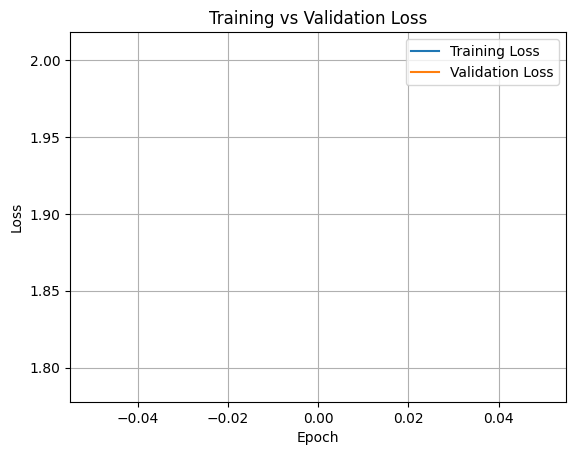

Epoch 2 / 100
------------------------------
Running phase train


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbe6ddc790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Running phase test


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fcbe6ddc790>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Saving to ShuffleNetV2_results.csv


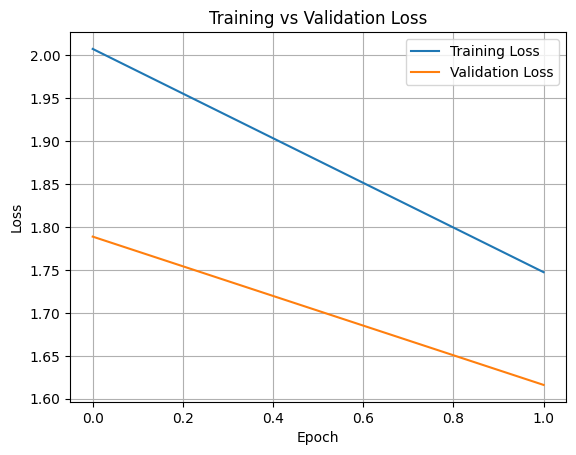

Epoch 3 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


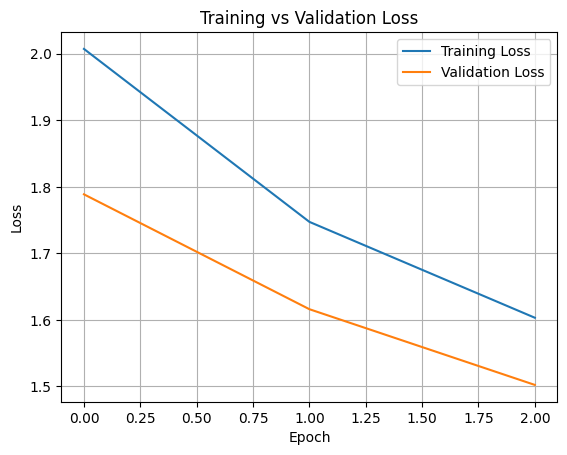

Epoch 4 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


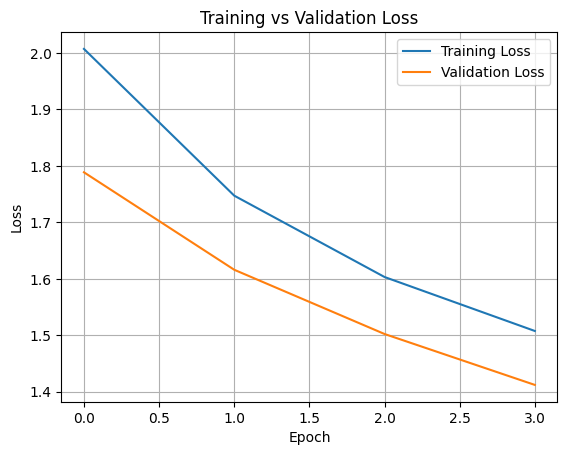

Epoch 5 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


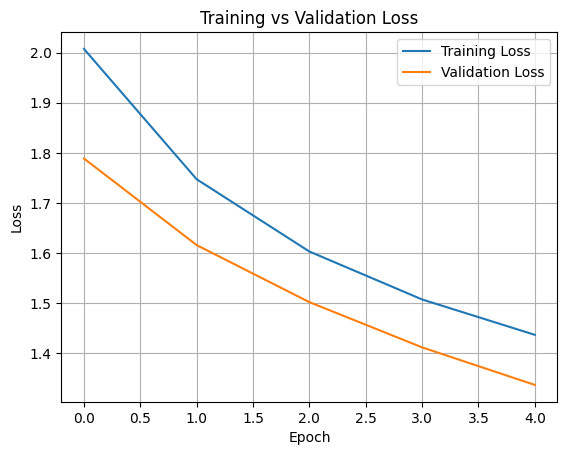

Epoch 6 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


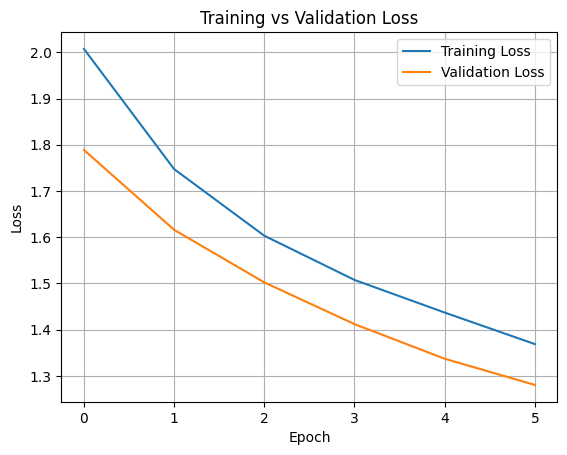

Epoch 7 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


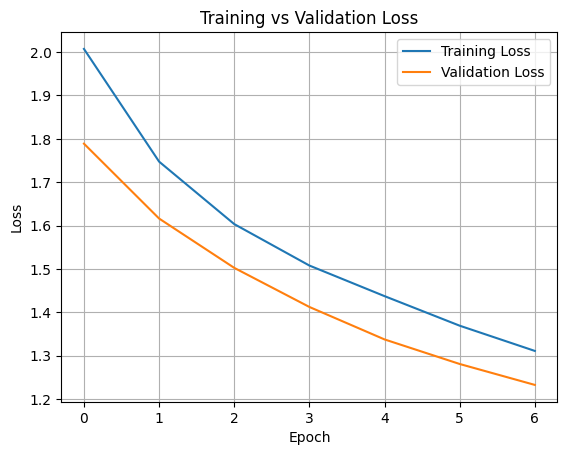

Epoch 8 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


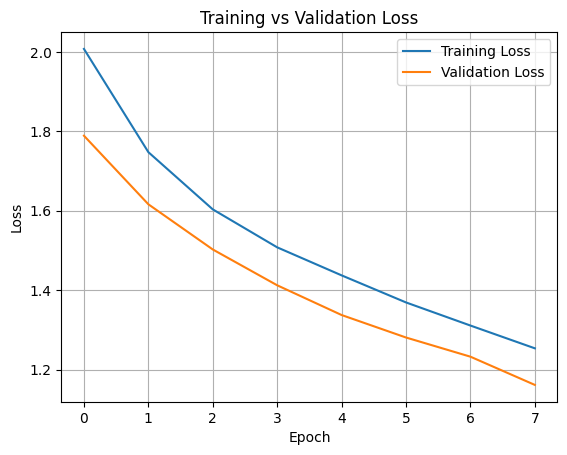

Epoch 9 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


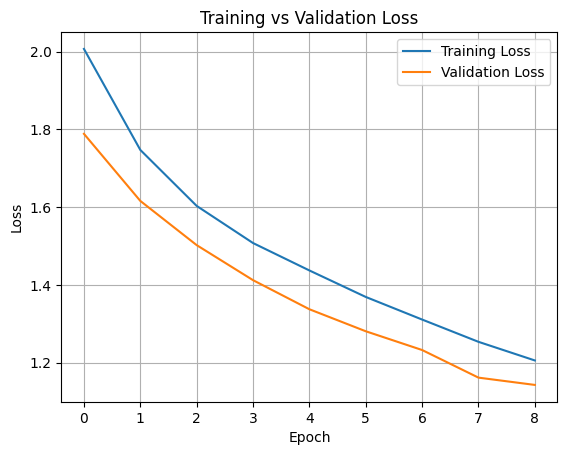

Epoch 10 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


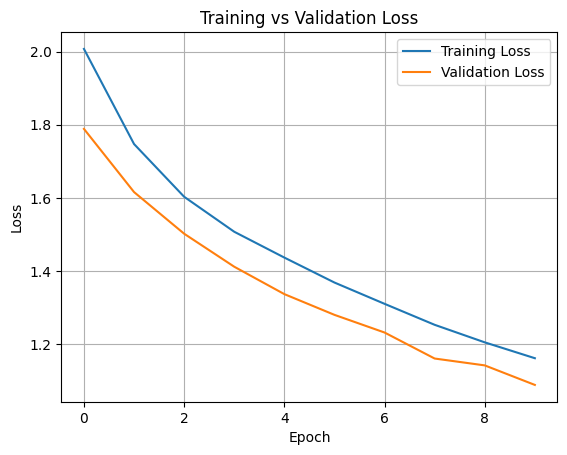

Epoch 11 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


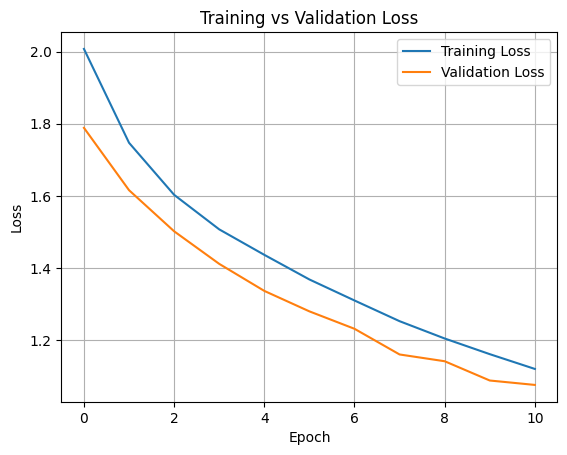

Epoch 12 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


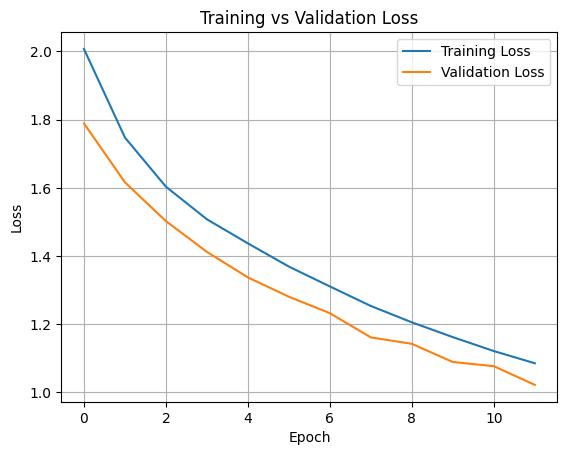

Epoch 13 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


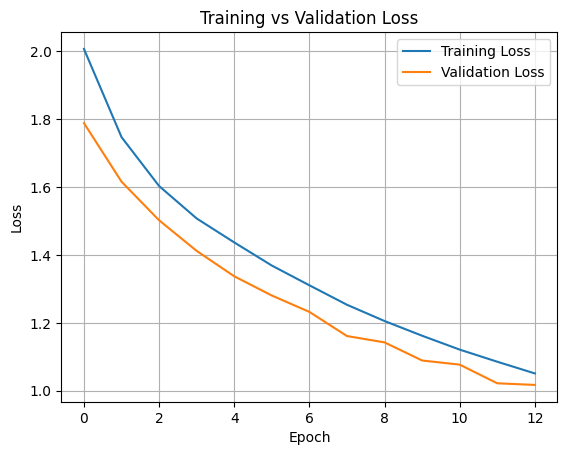

Epoch 14 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


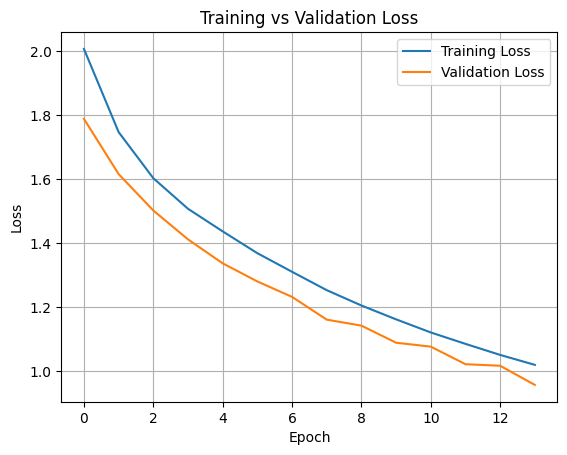

Epoch 15 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


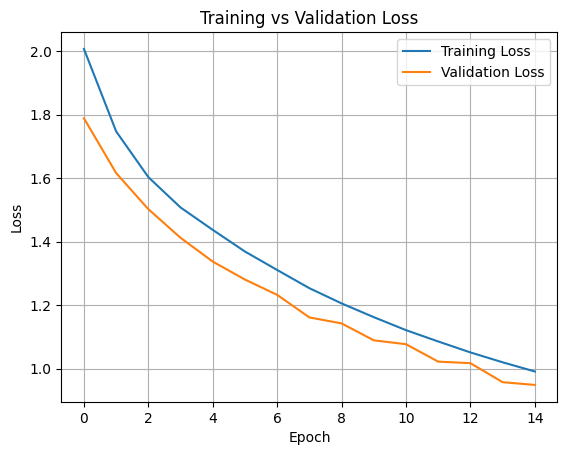

Epoch 16 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


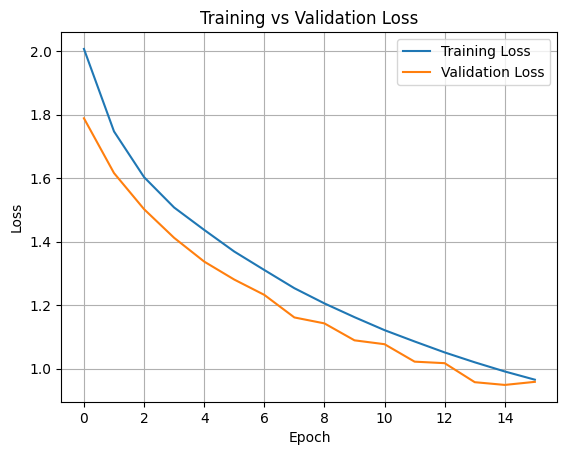

Epoch 17 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


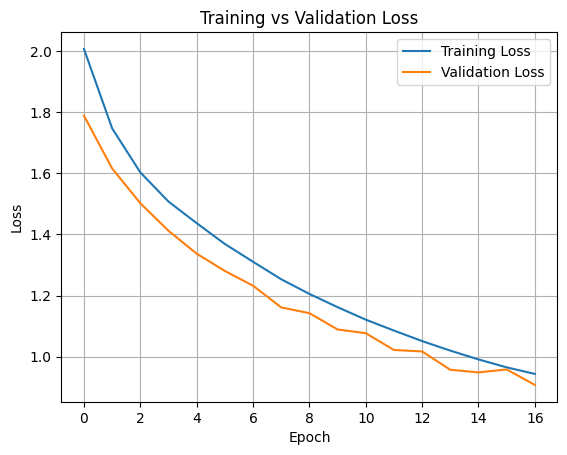

Epoch 18 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


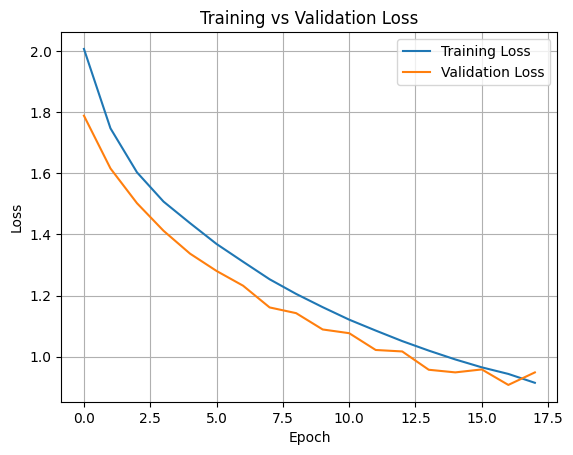

Epoch 19 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


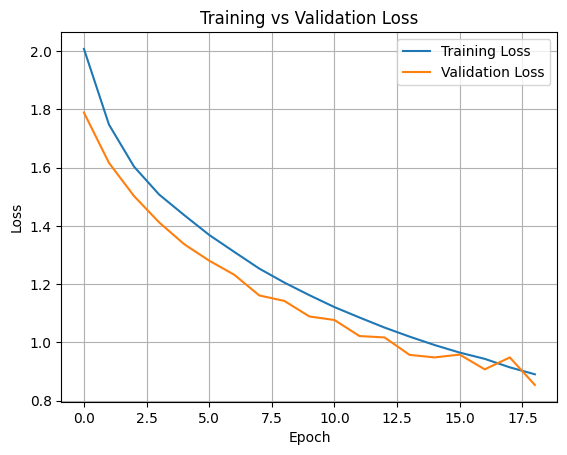

Epoch 20 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


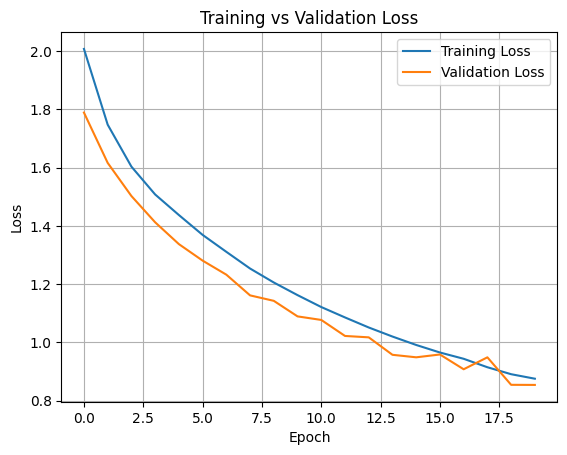

Epoch 21 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


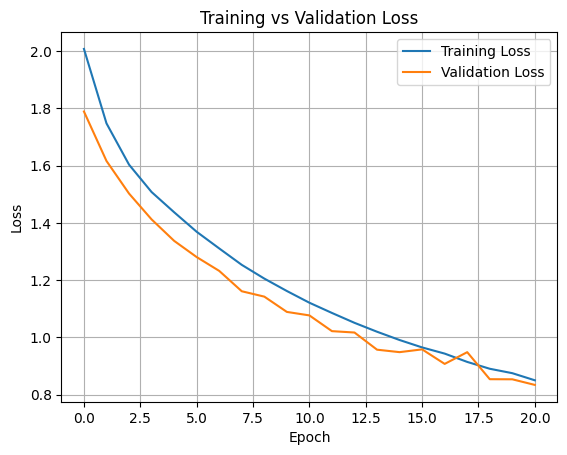

Epoch 22 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


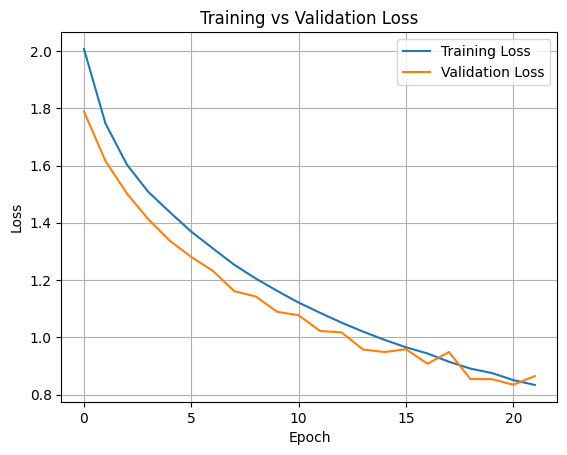

Epoch 23 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


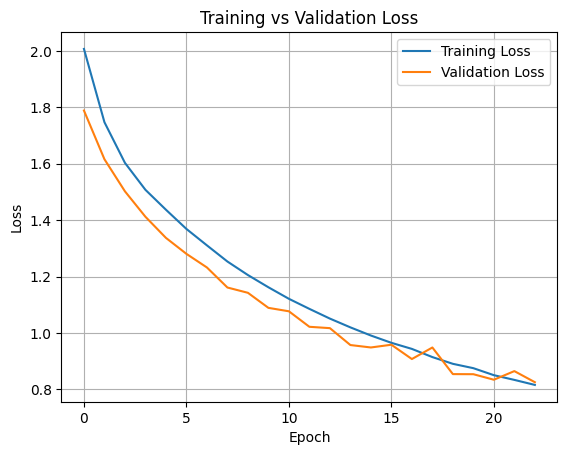

Epoch 24 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


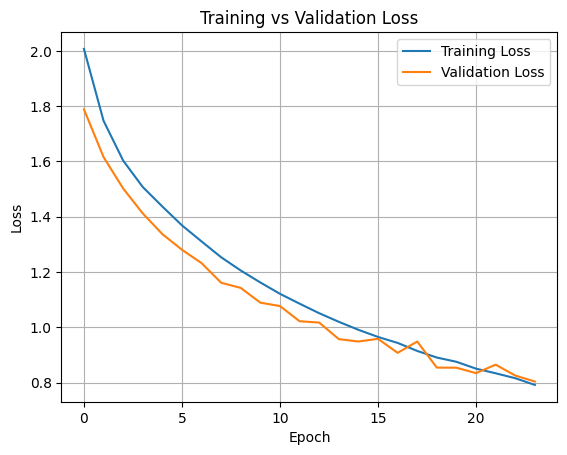

Epoch 25 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


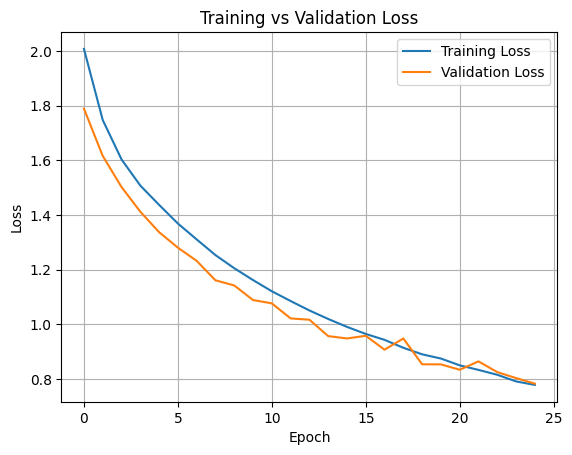

Epoch 26 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


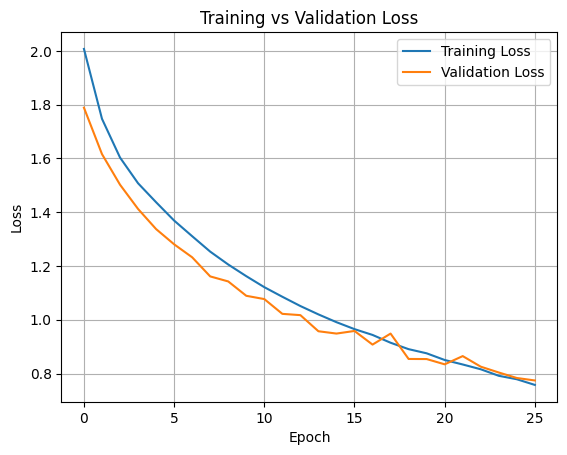

Epoch 27 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


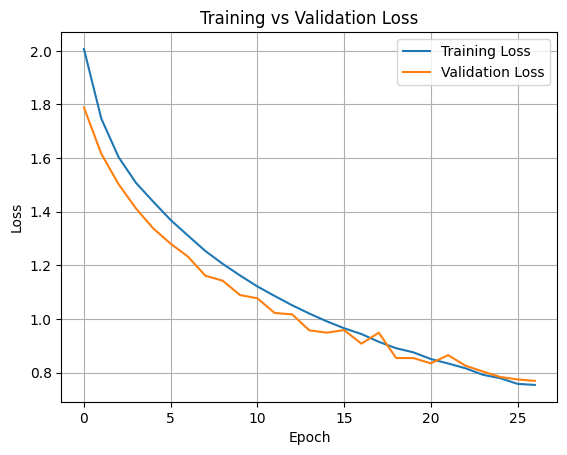

Epoch 28 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


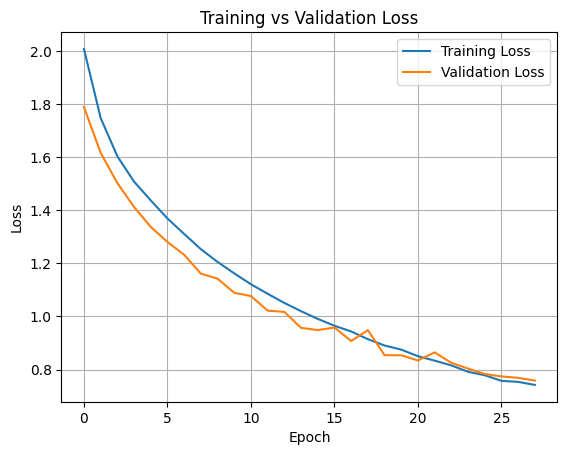

Epoch 29 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


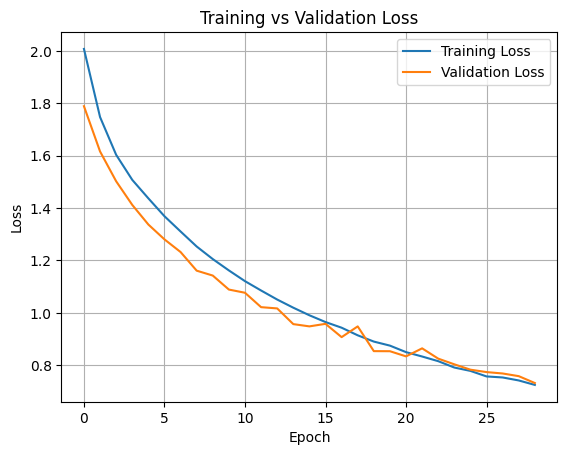

Epoch 30 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


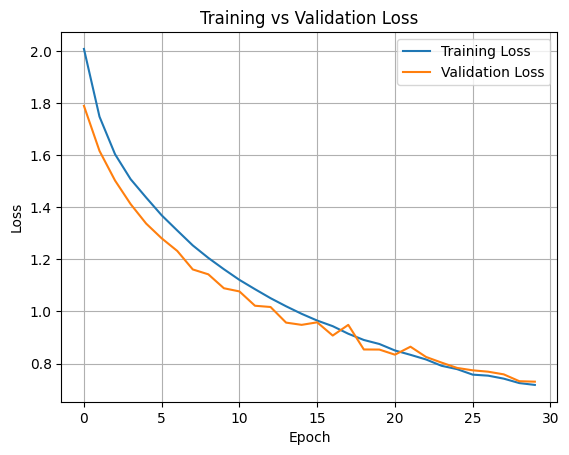

Epoch 31 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


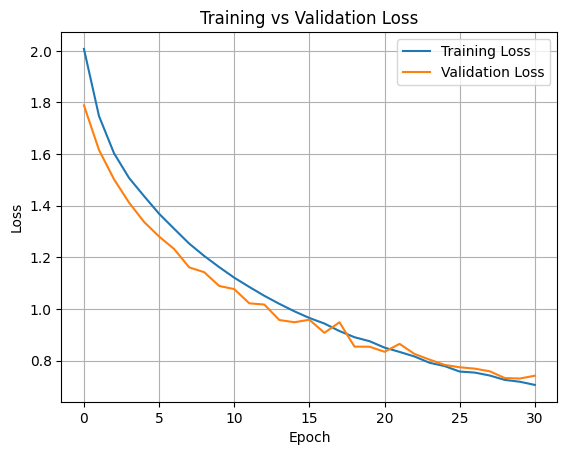

Epoch 32 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


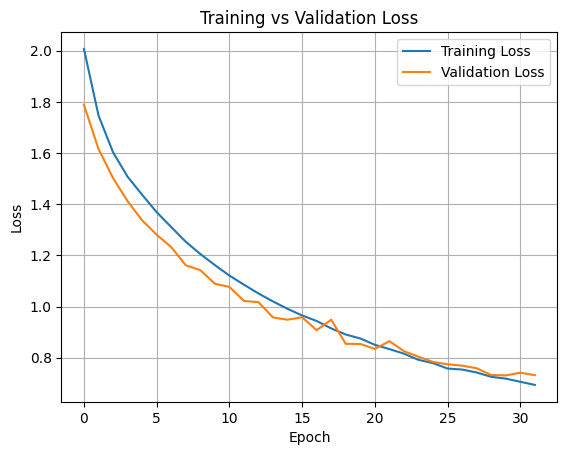

Epoch 33 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


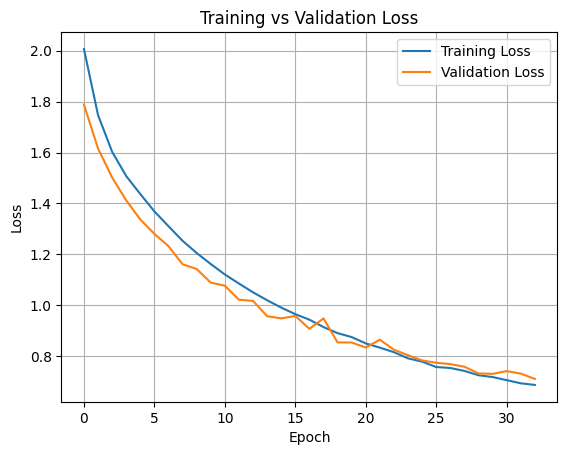

Epoch 34 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


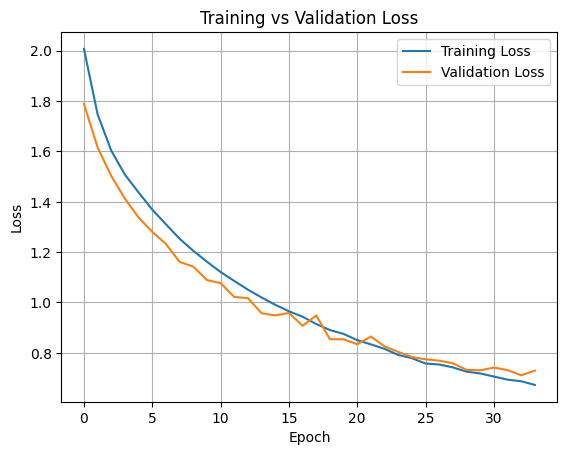

Epoch 35 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


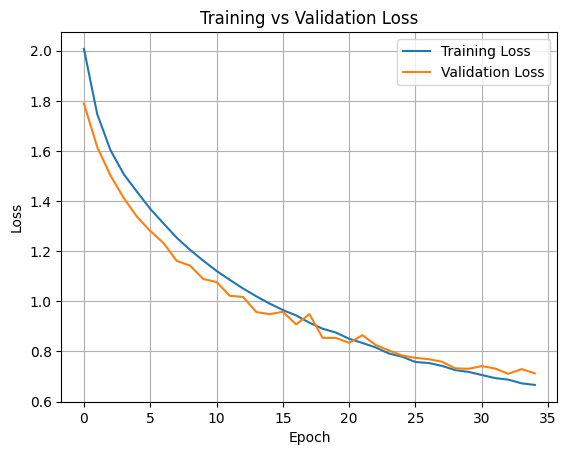

Epoch 36 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


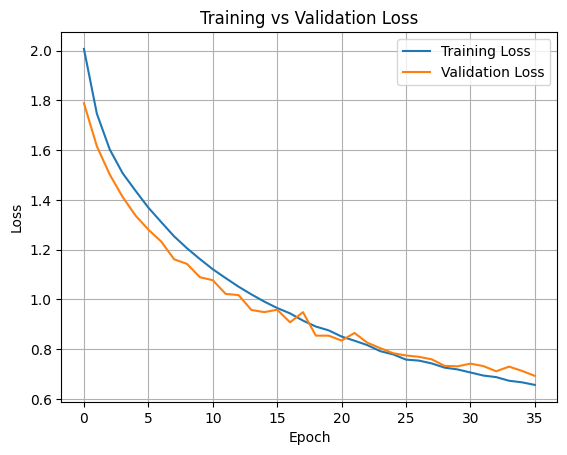

Epoch 37 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


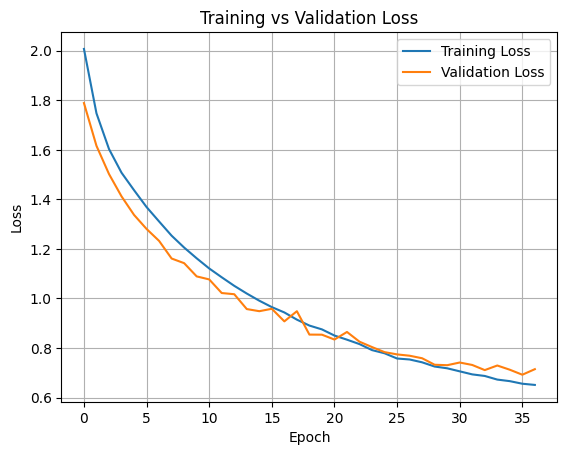

Epoch 38 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


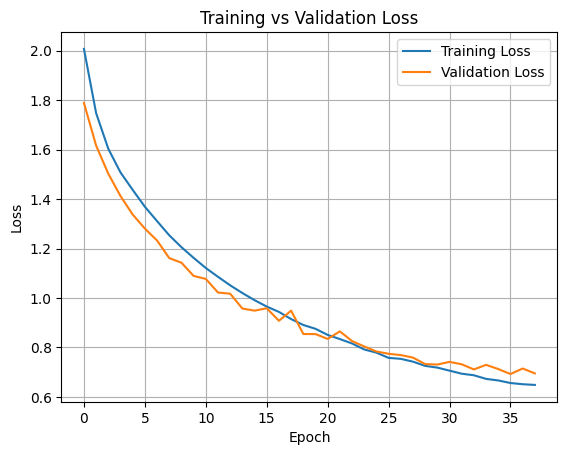

Epoch 39 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


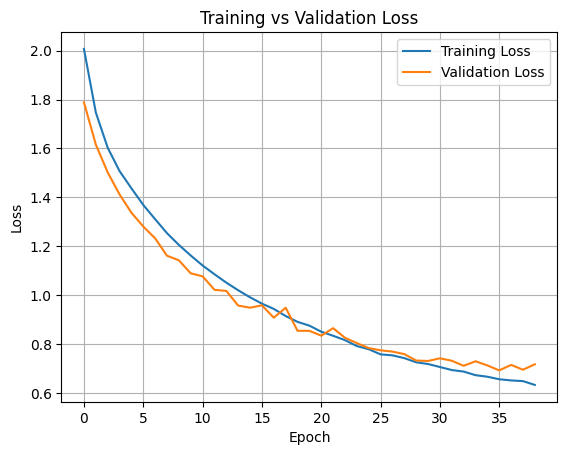

Epoch 40 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


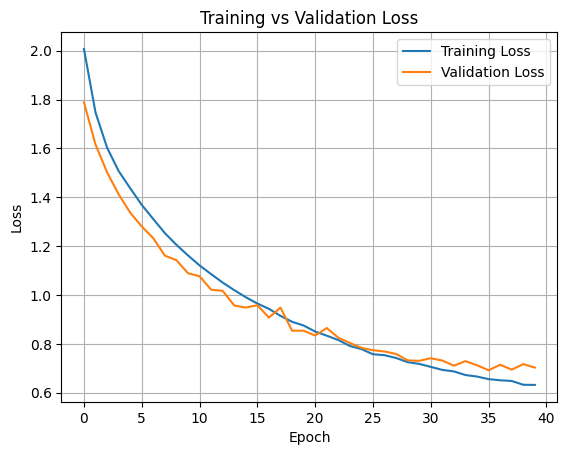

Epoch 41 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


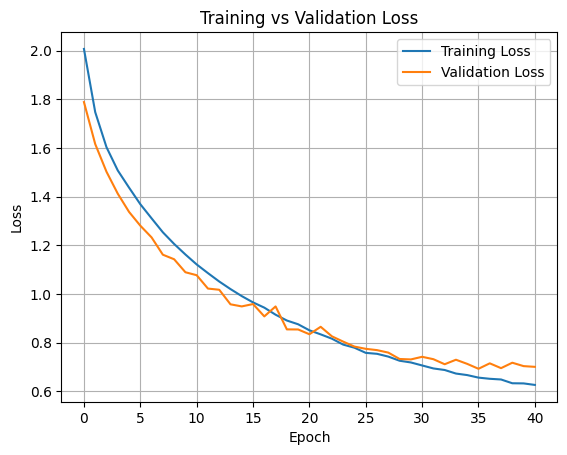

Epoch 42 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


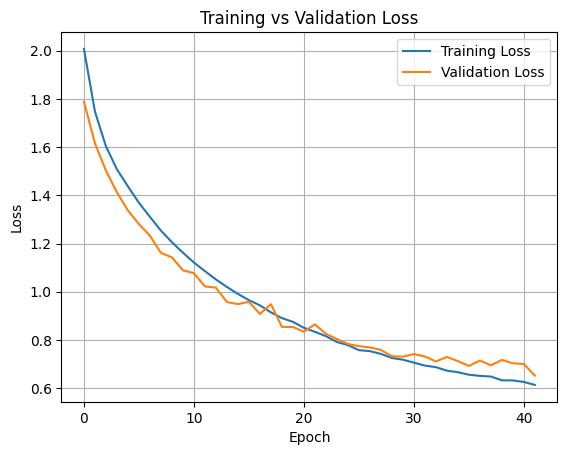

Epoch 43 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


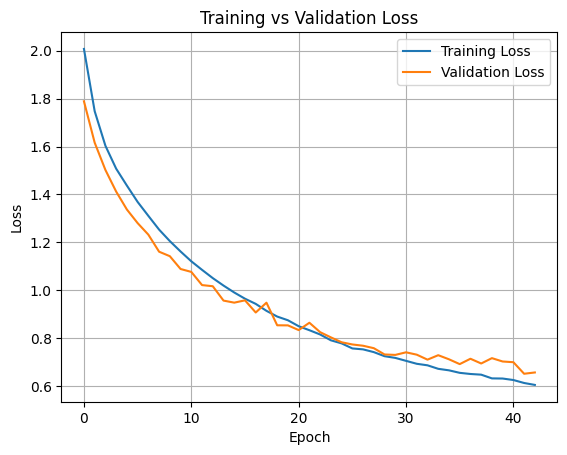

Epoch 44 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


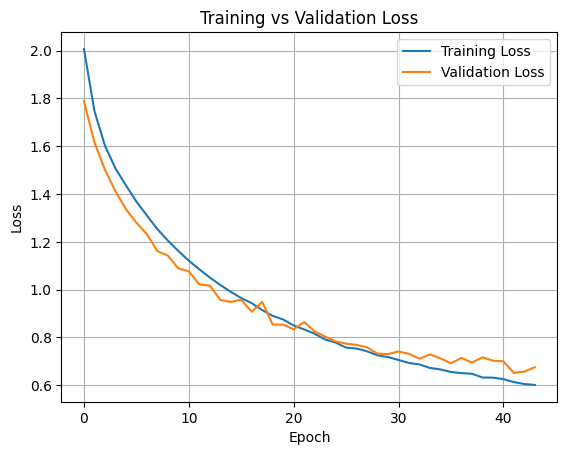

Epoch 45 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


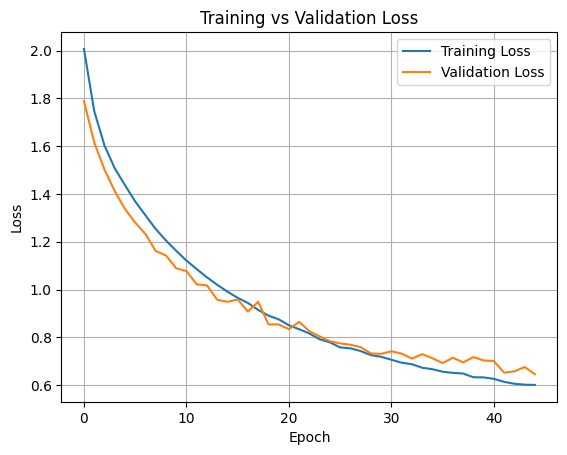

Epoch 46 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


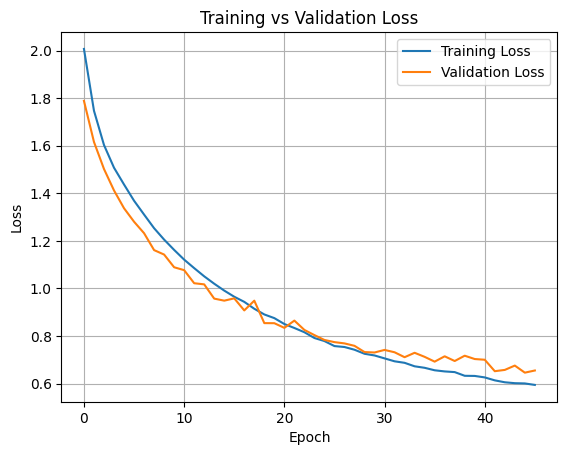

Epoch 47 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


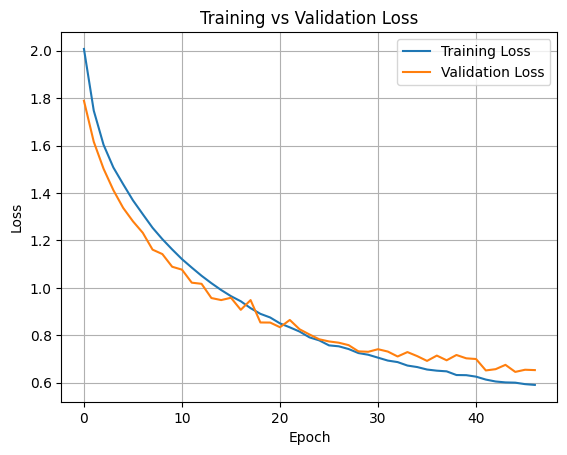

Epoch 48 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


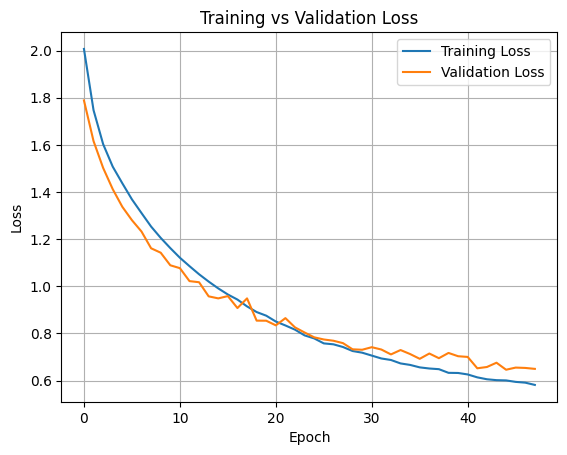

Epoch 49 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


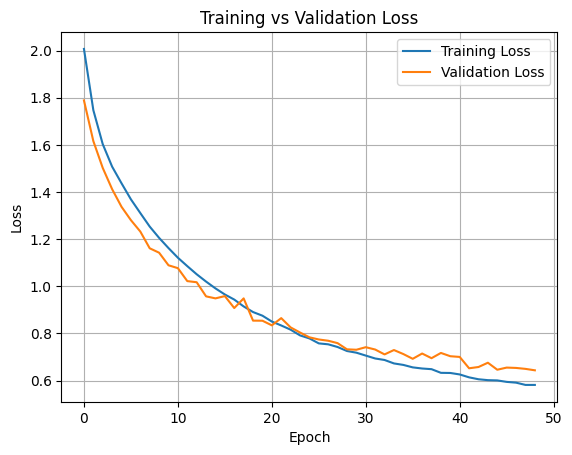

Epoch 50 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


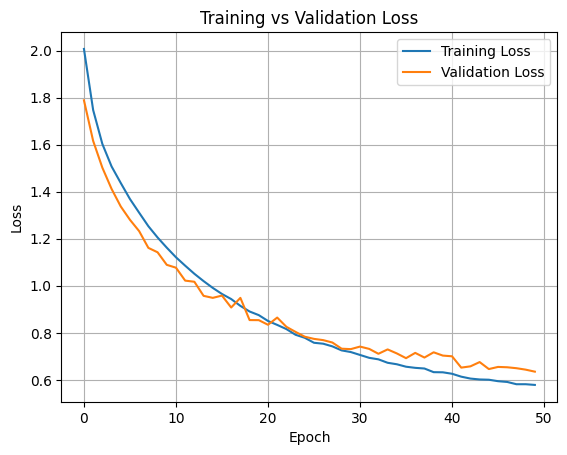

Epoch 51 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


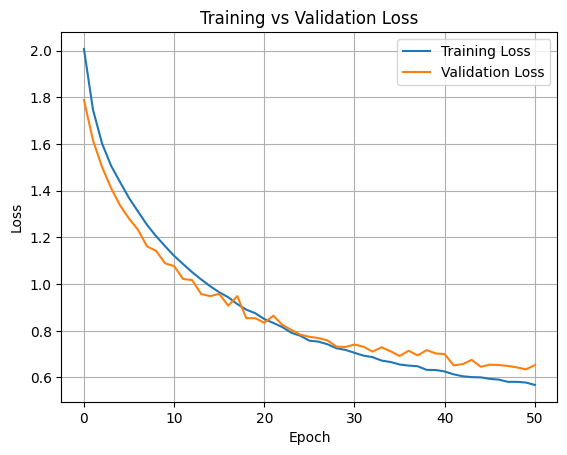

Epoch 52 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


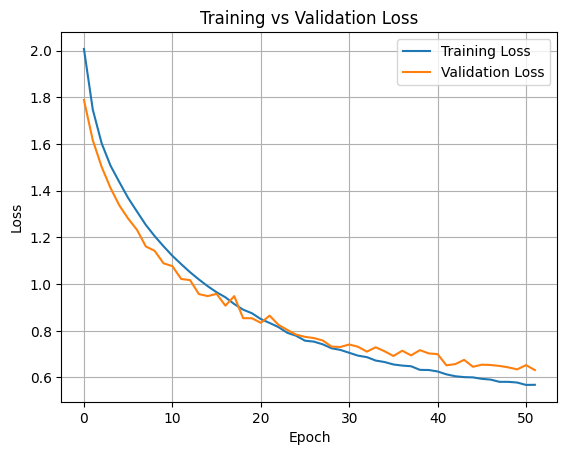

Epoch 53 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


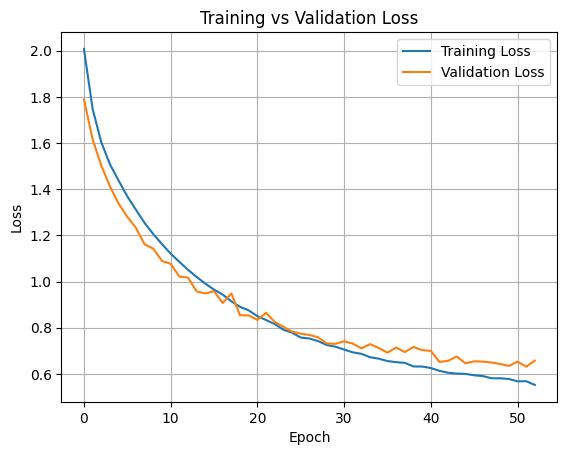

Epoch 54 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


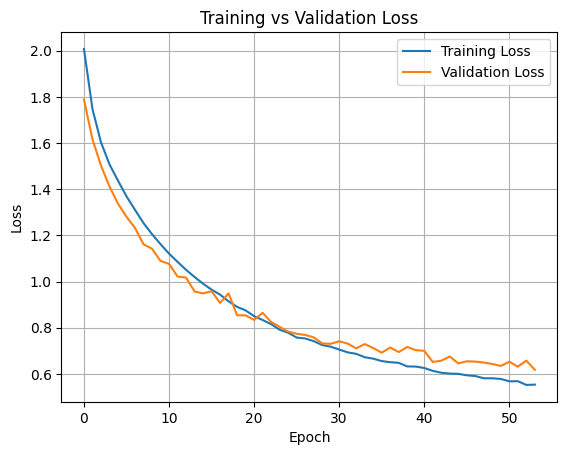

Epoch 55 / 100
------------------------------
Running phase train
Running phase test
Saving to ShuffleNetV2_results.csv


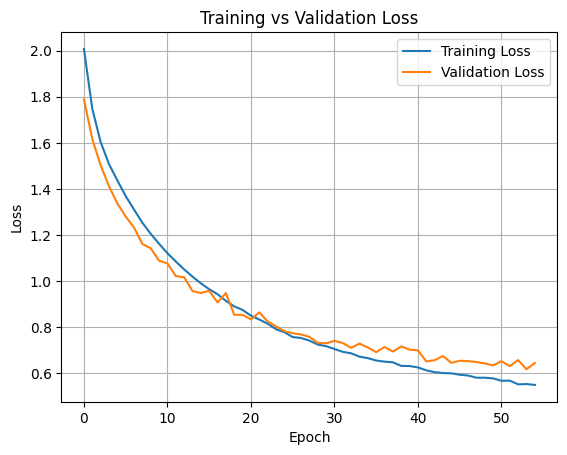

Epoch 56 / 100
------------------------------
Running phase train


KeyboardInterrupt: ignored

In [19]:
torch.manual_seed(1234) # recently added, older results are not reproducible
# model = se_model().to(device) # updated model file to not include device
model = base_model()
init_params(model)
model = model.to(device)
# 5e-3 is pretty effective for SE model
train(model, device, 128, 1e-3, beta0=0.9, beta1=0.999, weight_decay=1e-4, epochs=100, lr_decay_rate=10, lr_decay_epochs=[100, 200])

on CPU it takes like an hour btw, 7 mins per epoch approximately

on gpu it's around 90s per epoch

In [ ]:
# for standard shufflenet probably optimal to start at 1e-2 and decay by 10 at 100 and 200 epochs and train 250-300 epochs total.

train(model, device, 128, 1e-2, beta0=0.9, beta1=0.999, weight_decay=4e-5, epochs=100, lr_decay_rate=10, lr_decay_epochs=[100, 200])